In [16]:
import torch
import torch.nn as nn
import torch.optim as optim


In [17]:

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 20)
        self.hidden_layer2 = nn.Linear(20, 20)
        self.hidden_layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)
        
    def forward(self, y):
        y = torch.tanh(self.hidden_layer1(y))
        y = torch.tanh(self.hidden_layer2(y))
        y = torch.tanh(self.hidden_layer3(y))
        y = self.output_layer(y)
        return y
    
    def U(self, y):
        return (self(y) - self(-y)) / 2


In [18]:
def physics_informed_loss(model, y, nu):
    y.requires_grad = True
    U = model.U(y)
    
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    
    # Equation 2.1
    f = -nu * U + ((1 + nu) * y + U) * U_y
    
    # Constraint U(-2) = 1
    g = model.U(torch.tensor([-2.0])) - 1
    
    physics_loss = torch.mean(f**2)
    condition_loss = torch.mean(g**2)
    
    total_loss = physics_loss + condition_loss
    return total_loss

In [22]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
nu = 0.4  # Assuming some value for λ

num_epochs = 20000
y_data = torch.linspace(-3, 3, 100).view(-1, 1)  # Example data for y

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = physics_informed_loss(model, y_data, nu)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 1.1238431930541992
Epoch 100, Loss: 0.011899980716407299
Epoch 200, Loss: 0.005837145261466503
Epoch 300, Loss: 0.0024876638781279325
Epoch 400, Loss: 0.0007699214620515704
Epoch 500, Loss: 0.00019129815336782485
Epoch 600, Loss: 6.442410813178867e-05
Epoch 700, Loss: 4.455972521100193e-05
Epoch 800, Loss: 4.1136783693218604e-05
Epoch 900, Loss: 3.9434555219486356e-05
Epoch 1000, Loss: 3.782753992709331e-05
Epoch 1100, Loss: 3.619174094637856e-05
Epoch 1200, Loss: 3.452587407082319e-05
Epoch 1300, Loss: 3.2834766898304224e-05
Epoch 1400, Loss: 3.1124422093853354e-05
Epoch 1500, Loss: 2.940160993603058e-05
Epoch 1600, Loss: 2.767360638245009e-05
Epoch 1700, Loss: 2.5948233087547123e-05
Epoch 1800, Loss: 2.4233651856775396e-05
Epoch 1900, Loss: 2.2538706616614945e-05
Epoch 2000, Loss: 2.08716191991698e-05
Epoch 2100, Loss: 1.9241000700276345e-05
Epoch 2200, Loss: 1.7654718249104917e-05
Epoch 2300, Loss: 1.6120584405143745e-05
Epoch 2400, Loss: 1.4645716873928905e-05
Epoch 

In [30]:
# Generate test data
y_test = torch.linspace(-2, 2, 100).view(-1, 1)
U_pred = model.U(y_test)

# Convert predictions to numpy for further use (if needed)
U_pred = U_pred.detach().numpy()


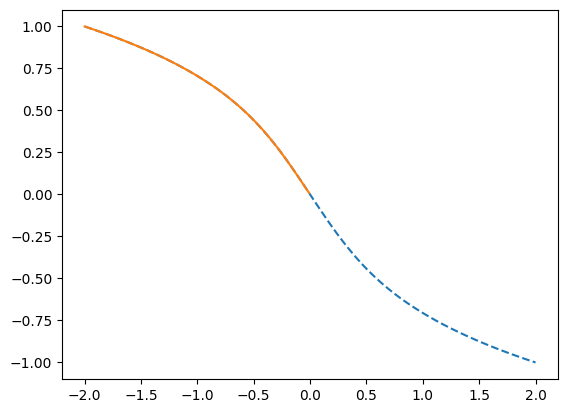

: 

In [37]:
import matplotlib.pyplot as plt
uu = torch.linspace(-1, 1, 100).view(-1, 1)
plt.plot(y_test,U_pred,'--',label='PINN')
plt.plot(-uu-uu**(1+1/nu),uu,label='exact')